In [1]:
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD import GD
import time
import imageio
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *
import numdifftools as nd

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)

# objective = f_class.Alpine(Noise, Noise_level) 
objective = f_class.Ackley(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# # objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
objective = f_class.Levy(Noise, Noise_level, dim=20)  
# objective = f_class.Rastrigin(Noise, Noise_level, dim=10)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
clean_f = lambda x: f_class.Ackley().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
clean_f = lambda x: f_class.Levy(dim=20).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]
 [ 7. 10.]]
dim:  20


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

### Grid

In [6]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [7]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [8]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [9]:
MAX = 400 # function observations

## Gradient-based Method

##### 1. Setup

In [10]:
# initial data
setup = 1
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [11]:
gp = GP_grad(B, Noise, Noise_level, compress=True)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
w = X[0].reshape(1, dim)
history = [(w, f(w))]

##### 2. Warm up

In [12]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
# warmup = 30
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history.append( (w, f(w)) )
    
# X_fix = X

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 15
for i in range(1, warmup+1):
    w = gp.thompson_sample(n_mesh=gp.dim*100)
    gp.add_data(w.reshape(1, dim), f(w))
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()    
                
    X = np.vstack([X, w])
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    history.append( (w, f(w)) )
    
X_fix = X

1, w:  [9.11830586 9.16205698 9.92219037 8.45122108 9.08527642 9.89484954
 9.02051842 7.65201792 7.27073243 9.52452356 7.53623831 7.51208176
 8.62481481 9.89521736 8.98816955 8.96385372 9.41331917 9.96990079
 7.44917153 7.86225018], f(w):  535.5376457358709, 
2, w:  [8.86608398 9.9659785  8.70959032 7.00805928 7.96532345 9.1897524
 7.49512456 7.02192055 8.5325672  8.99171829 9.19745803 7.41820033
 7.08613052 9.37844133 9.13098449 7.10134967 9.13344979 8.4391388
 7.23033877 7.74914263], f(w):  389.453965457735, 
3, w:  [8.9042629  8.13504165 9.6147958  7.57956707 7.44440001 7.63068774
 9.5972867  7.19559131 7.75866032 9.98756206 9.89740193 9.73063397
 7.86291599 7.50375327 9.47498548 8.38308117 9.17673671 9.30519825
 8.35637763 7.92537427], f(w):  450.29370056467013, 
4, w:  [9.94757909 7.36143833 8.61279386 8.1687268  7.86788282 8.20392239
 9.83732402 9.94407344 9.98192495 7.81383863 9.56356794 8.06513354
 8.66726542 9.23312926 7.69945395 9.75149834 8.63022482 7.04476553
 9.11786062 8.

In [14]:
gp.get_normal()

(431.00425154648605, 70.6300465835311)

##### 3. Optimize via GD

In [15]:
from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
# gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

In [16]:
gp.optimize()
np.set_printoptions(precision=4)
cost = setup + warmup
lr = 0.1
y_best = np.min(f(gp.X))

# create a candidate list of GD points from all queried points so far
GD_House = [GD(gp, B, w, f) for w in gp.X]

In [17]:
ts_count = 0
print("starting best: ", y_best)
while cost <= MAX:
    print(cost, end = '. ')
    y_best = np.min(f(gp.X))
    y_best_No = np.argmin(f(gp.X))
    maxPI = 0
    minEI = 0

    All_GD_path = []
    active_GD_No = []
    
    # pick the potential GD -> min so far
    GD_cand = sorted(filter(lambda x: x.Fail < x.stop, GD_House), key=lambda x: x.minSofar)[:1]
    GD_cand_No = [GD_House.index(cand) for cand in GD_cand]

    best_GD_No = -1
    for i in range(len(GD_House)):
        if i in GD_cand_No:
            print(gp._unnormal_grad(lr))
            w, GD_path = GD_House[i].no_update_sample(y_best=y_best, lr=gp._unnormal_grad(lr)) # gp._unnormal_grad(lr)
            All_GD_path.append(GD_path)
            active_GD_No.append(i)

            # EI
            if gp.EI(w, GD_House[i].minSofar) < minEI:
                minEI = gp.EI(w, GD_House[i].minSofar)
                best_W = w
                best_GD_No = i
                 
              # PI
#             if gp.PI(w, GD_House[i].minSofar) > maxPI:
#                 maxPI = gp.PI(w, GD_House[i].minSofar)
#                 best_W = w
#                 best_GD_No = i

    if best_GD_No == -1:
        maxPI = 0
    else:
        maxPI = gp.PI(best_W, GD_House[best_GD_No].minSofar)

    if np.random.uniform(0, 1, 1) < maxPI:
        best_GD = GD_House[best_GD_No]
        print('GD Query with ', maxPI)
        print('    GD No, Loops, MinSofar = ', (best_GD_No, len(best_GD.history_full_w), best_GD.minSofar.item()))
        w = best_W
              
        # update that GD optimizer
        best_GD.history_full_w = All_GD_path[active_GD_No.index(best_GD_No)]
        best_GD.w = w
        best_GD.history_w.append(w)

        if f(w) < best_GD.minSofar:
            best_GD.Fail = 0
            best_GD.minSofar = f(w)
        else:
            best_GD.Fail += 1
            
        if len(best_GD.history_full_w) > 405:
            best_GD.stop = 0
              
#     if np.abs(minEI) > delta:
#         print('GD suggests with EI, delta = ', np.abs(minEI), delta)
#         print('   GD (i, loop) ', (bestIndex, len(optHouse[bestIndex].history_full_w) ))
#         w = bestW
    else:
        w = gp.thompson_sample(n_mesh=2000)
        print('Thompson Query with Pr = ', 1 - maxPI)
#         print('UCB suggests with EI, delta ', np.abs(minEI), delta)
        ts_count += 1
        GD_House.append(GD(gp, B, w, f))
        print('    Thompson No. ', ts_count)

    if is_new(w, gp.X) == False:
        print(w)
        print(gp.posterior_full_grad('full', dim*[w])[0])
        raise ValueError('  ? hit past points')

    gp.add_data(w.reshape(1, -1), f(w))
    cost += 1
        
    # online hyper udpate + fitting GP with new query w
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    
    history.append( (w, f(w)) )
    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.4f ' % f(w).item())
    print('    d(w): ', np.squeeze(m))
    print('    s.d: ', np.squeeze(v))
    print('    g(w):', gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)))
    print('    y best, No:', y_best, [y_best_No])
    print()
        
print('Max Cost reached = ', cost)

starting best:  249.29612432257773
16. 7.06300465835311
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9943]
    Thompson No.  1
    w:  [9.8725 8.2316 7.5192 8.1976 9.7068 9.501  9.9807 7.6943 9.2065 7.7965
 8.2788 7.4892 9.965  8.0945 8.0152 9.1435 9.1041 9.2923 7.3669 9.3081],     f(w): 421.0032 
    d(w):  [ 1.9893e-23  1.1783e-23  2.3032e-24 -7.7866e-24  4.6784e-24  9.4301e-24
  5.7218e-25  6.9133e-24  7.0982e-24 -2.7072e-24  4.5207e-24 -4.2215e-24
  8.3332e-24 -5.0829e-24  1.0638e-23  7.9637e-24  1.2111e-23 -2.3502e-24
 -1.3859e-23  1.6634e-23]
    s.d:  [3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435
 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435 3.1435]
    g(w): [ 0.0112  0.2998 -0.0825  0.2804  0.1917  0.3455 -0.0506 -0.0041  0.4929
  0.0489  0.3261 -0.0941 -0.0362  0.2203  0.1736  0.5112  0.5202  0.4601
 -0.1349  0.0999]
    y best, No: 249.29612432257773 [5]

17. 6.852381753829889
confidence level =  0.0
GD loop:  0


    w:  [7.2175 8.8788 8.0131 8.9005 8.7503 9.3487 7.411  9.3333 7.3567 8.2316
 7.738  7.5501 7.0168 8.866  7.8671 9.2125 7.1417 8.5332 9.3718 8.6911],     f(w): 347.6252 
    d(w):  [-1.7123e-08 -1.2585e-09 -1.2551e-08  8.0294e-09 -5.4005e-09  7.9036e-09
 -6.3817e-10 -2.3682e-09  5.8468e-11 -1.1285e-08  3.6632e-09 -1.0749e-09
 -2.0089e-08  1.8036e-09 -8.5920e-09  6.0810e-09 -1.7035e-08  1.4486e-08
  1.9904e-08  7.3957e-09]
    s.d:  [1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882
 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882 1.7882]
    g(w): [-0.0039  0.5474  0.1762  0.5486  0.5292  0.4437 -0.1241  0.4514 -0.1409
  0.3066  0.0185 -0.0715 -0.1955  0.5464  0.0899  0.502  -0.1857  0.4599
  0.4317 -0.054 ]
    y best, No: 249.29612432257773 [5]

26. 6.70053314797066
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9947]
    Thompson No.  11
  # Optimal (ls, var) =  (0.5590152254400325, 1.0812312418729002)
    w:  [7.9308 8.3706 8.6

confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.995]
    Thompson No.  19
    w:  [9.7958 7.4712 8.3296 7.3641 7.7444 8.0949 7.7006 8.4289 8.6161 9.3514
 8.5903 9.2095 7.9883 9.9106 7.0655 9.6438 8.6083 9.4795 8.1357 7.0436],     f(w): 355.3577 
    d(w):  [-2.4932e-73  3.1524e-73  1.3216e-73  1.8318e-73 -5.2170e-74  1.9237e-73
  2.0767e-73 -2.7928e-73  1.6471e-74 -4.5861e-73  2.2776e-73  8.6429e-74
  7.4489e-74 -3.0014e-73  2.4183e-74  9.7201e-75  1.0223e-73 -8.4841e-74
  3.6619e-73  1.1221e-73]
    s.d:  [4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676
 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676 4.6676]
    g(w): [ 0.0109 -0.1008  0.3539 -0.1359  0.0214  0.2208 -0.0009  0.4041  0.4812
  0.4331  0.4722  0.4925  0.158   0.0135 -0.189   0.2426  0.4786  0.3599
  0.2448  0.0183]
    y best, No: 249.29612432257773 [5]

35. 6.843831033309709
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9949]
    Thompson No.  20


Thompson Query with Pr =  [0.9939]
    Thompson No.  28
    w:  [7.9008 8.2583 7.8817 8.4388 9.7023 7.0294 9.699  9.6591 7.7064 8.2498
 7.3084 8.9204 8.6943 8.9321 8.4414 9.063  9.8327 7.8648 8.8494 8.3567],     f(w): 423.7491 
    d(w):  [-3.7214e-44  9.6735e-45  7.4227e-44 -1.1962e-44 -1.1144e-45  8.6773e-44
 -3.9349e-44 -1.1518e-43  6.8066e-44 -5.9381e-44 -1.6040e-44  4.2407e-44
 -4.2587e-45 -1.0653e-44  1.2833e-44 -2.9686e-44  1.0373e-44  5.4589e-45
  6.2627e-44  2.4814e-44]
    s.d:  [3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346
 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346 3.5346]
    g(w): [-0.0115  0.3192  0.0975  0.4141  0.1982 -0.1934  0.2009  0.2336  0.002
  0.3144 -0.1528  0.5447  0.5114  0.5449  0.4154  0.5351  0.0847  0.0879
  0.5404 -0.0474]
    y best, No: 249.29612432257773 [5]

44. 6.756372904251918
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9944]
    Thompson No.  29
  # Optimal (ls, var) =  (0.42218921

    g(w): [-0.0071  0.4405  0.506   0.1858  0.5497  0.3337  0.5198  0.3782  0.505
  0.5094  0.0245  0.2821 -0.1728  0.1205  0.2737  0.1715 -0.1577  0.4224
  0.5442  0.0311]
    y best, No: 249.29612432257773 [5]

53. 6.621306862421488
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9952]
    Thompson No.  38
  # Optimal (ls, var) =  (0.5045596937502248, 1.0365349490937923)
    w:  [9.6136 7.2953 8.5839 9.574  8.0153 8.998  7.0696 9.8111 9.471  8.3025
 7.6122 9.2578 8.902  7.5699 9.7264 9.2565 8.3755 8.9564 8.0167 9.4381],     f(w): 450.9740 
    d(w):  [-9.7089e-13  9.3697e-12 -1.4663e-11 -2.0448e-11  1.1995e-11  4.0717e-12
  4.0059e-11 -6.6883e-12  7.4597e-12 -4.6819e-12 -7.6768e-12  1.0732e-12
  3.9551e-12  1.1929e-11 -5.5173e-12 -9.6645e-12  5.5156e-12 -1.2395e-11
  1.5223e-11  2.3705e-12]
    s.d:  [2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178
 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178 2.0178]
    g(w): [ 0.0098 -0.1602

  # Optimal (ls, var) =  (1.0, 1.0473181483141516)
    w:  [8.2099 9.1459 8.6341 8.4798 9.4021 7.698  7.2319 9.3819 8.1578 7.7772
 7.0659 8.9154 7.7124 7.0737 9.2038 9.4802 7.6728 9.8533 8.483  7.9734],     f(w): 392.7100 
    d(w):  [-0.0016  0.0018  0.0029  0.0037  0.0026 -0.004  -0.004   0.0018  0.004
 -0.0016 -0.002  -0.0022  0.0009 -0.003   0.0055  0.0019  0.0016  0.0017
  0.0004 -0.0033]
    s.d:  [1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234
 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234 1.0234]
    g(w): [-0.0111  0.5245  0.4997  0.4387  0.4168 -0.0023 -0.172   0.4281  0.2644
  0.0397 -0.1939  0.5516  0.0051 -0.1933  0.5072  0.3688 -0.015   0.067
  0.4401  0.0321]
    y best, No: 249.29612432257773 [5]

63. 6.671180853406901
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9947]
    Thompson No.  48
    w:  [8.9296 9.9739 9.0702 9.2892 7.9841 9.9137 7.9204 7.436  7.9021 7.9926
 8.1693 9.4301 9.3366 9.6271 9.2717 8.5067 8

Thompson Query with Pr =  [0.9953]
    Thompson No.  57
    w:  [8.6796 7.2365 9.9718 7.6244 8.1603 8.0069 9.0106 8.5373 8.4199 7.9848
 9.6046 8.4728 9.0609 7.3511 9.272  8.9984 9.3912 7.6331 9.8283 8.3522],     f(w): 424.7480 
    d(w):  [ 7.7351e-16  8.2505e-16 -4.2226e-17  3.6636e-16 -1.8707e-16  1.1858e-15
 -1.4418e-16 -1.3889e-15 -5.4541e-16  9.1418e-16 -1.0205e-15  8.5942e-17
 -2.4738e-16 -2.4713e-16  5.3534e-16 -1.5800e-15  9.8610e-17  2.0690e-15
 -1.5557e-16  1.2059e-16]
    s.d:  [2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539
 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539 2.4539]
    g(w): [-0.0058 -0.174  -0.0444 -0.0392  0.2704  0.1762  0.5578  0.4716  0.4172
  0.1627  0.2845  0.4429  0.5515 -0.1456  0.4896  0.5588  0.4301 -0.035
  0.0913 -0.0482]
    y best, No: 249.29612432257773 [5]

73. 6.559129629937111
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9955]
    Thompson No.  58
    w:  [8.3758 7.975  8.6718 8.3673

Thompson Query with Pr =  [0.9943]
    Thompson No.  67
    w:  [8.3379 9.4791 9.8314 9.664  7.5204 7.7598 7.6255 8.9457 8.5095 7.9467
 9.5911 8.1887 8.5445 9.0357 9.717  8.7727 8.4838 9.7857 7.2572 9.2993],     f(w): 473.3936 
    d(w):  [ 2.0056e-08  2.3505e-08 -1.0644e-09  4.8592e-09 -4.4487e-09  1.0056e-08
  3.4677e-09  1.5809e-08 -1.7554e-08  3.5167e-09 -5.6712e-09 -5.3654e-09
  2.0323e-08  1.6127e-08  1.6611e-08  1.8496e-08  5.1782e-09 -4.2235e-09
  2.2020e-09  4.4889e-09]
    s.d:  [1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492
 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492 1.6492]
    g(w): [-0.0101  0.369   0.0869  0.2323 -0.0841  0.0302 -0.0379  0.5511  0.4513
  0.1369  0.2897  0.2824  0.4661  0.545   0.188   0.5353  0.4399  0.128
 -0.1666  0.1005]
    y best, No: 249.29612432257773 [5]

83. 6.6795734667218
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9946]
    Thompson No.  68
  # Optimal (ls, var) =  (0.5967832793

Thompson Query with Pr =  [0.9931]
    Thompson No.  77
  # Optimal (ls, var) =  (0.15955231850706783, 1.0491597777557153)
    w:  [9.1436 8.178  8.4817 9.259  7.634  8.5997 9.7105 7.716  9.3886 8.7633
 7.6012 7.3698 8.865  8.9733 8.4851 9.4918 9.6712 8.7791 9.369  7.3692],     f(w): 460.5896 
    d(w):  [ 1.7465e-74 -2.3092e-73  1.5341e-73  1.7474e-73 -1.1833e-73  3.6745e-74
  6.9620e-74 -1.9094e-74  2.2680e-73  1.7155e-73 -2.4279e-73 -1.8014e-73
 -8.5031e-74  2.2927e-73  3.6602e-74  2.6275e-74  1.9586e-73 -4.4905e-74
 -7.8834e-74  6.3988e-74]
    s.d:  [6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197
 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197 6.4197]
    g(w): [ 0.0026  0.2765  0.4396  0.4868 -0.0339  0.4879  0.1938  0.007   0.4244
  0.5343 -0.0493 -0.1377  0.5489  0.5511  0.4411  0.3611  0.2267  0.5373
  0.4351  0.0703]
    y best, No: 249.29612432257773 [5]

93. 6.6700024356691445
confidence level =  0.0
GD loop:  0
Thompson Query with Pr 

Thompson Query with Pr =  [0.9931]
    Thompson No.  86
  # Optimal (ls, var) =  (1.0, 1.0244487459747351)
    w:  [8.7281 7.3848 7.3299 9.4976 8.294  8.2393 7.4078 8.2509 9.5491 9.4912
 7.2543 9.3846 7.9582 8.5397 7.3539 8.4547 8.5785 7.0302 8.8339 7.2089],     f(w): 329.4042 
    d(w):  [ 0.0005 -0.0003 -0.0015  0.0011  0.0008  0.0009 -0.001  -0.0002  0.0006
  0.0015 -0.0012  0.0009 -0.0005  0.0005 -0.0003  0.0004  0.0007 -0.001
  0.0007 -0.0013]
    s.d:  [1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122
 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122 1.0122]
    g(w): [-0.0049 -0.1334 -0.1494  0.3579  0.3442  0.313  -0.126   0.3197  0.3218
  0.3621 -0.1677  0.4274  0.1443  0.4656 -0.1426  0.4278  0.4809 -0.1962
  0.5466  0.0476]
    y best, No: 249.29612432257773 [5]

102. 6.658439952677902
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9932]
    Thompson No.  87
    w:  [8.6661 9.8146 7.0243 8.2223 8.9041 8.7286 8.1946 9.5247 

Thompson Query with Pr =  [0.9927]
    Thompson No.  96
    w:  [7.5248 8.9306 9.6055 8.6946 9.7238 9.8147 7.3733 9.5836 8.1903 8.8877
 8.1414 8.0723 7.5249 7.3927 7.9203 8.2217 8.4103 9.073  9.9379 7.4952],     f(w): 433.8437 
    d(w):  [ 1.0812e-44  1.8245e-45  5.6023e-44 -7.2449e-45  3.4247e-44  1.6393e-44
 -1.3274e-45  8.8050e-45  2.9326e-44  2.3080e-44  1.4191e-44  1.8369e-44
  1.7877e-44 -5.1831e-44  1.8710e-45 -3.4857e-44  4.4629e-44  1.8990e-44
  1.9916e-44 -4.2072e-44]
    s.d:  [4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902
 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902 4.0902]
    g(w): [-0.0087  0.554   0.2802  0.52    0.1831  0.1026 -0.1372  0.297   0.2848
  0.5525  0.2555  0.2137 -0.0827 -0.1311  0.1219  0.3033  0.4069  0.5424
 -0.0118  0.0806]
    y best, No: 249.29612432257773 [5]

112. 6.645300528086863
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9931]
    Thompson No.  97
    w:  [8.5178 9.1934 7.6693 8.00

Thompson Query with Pr =  [0.9909]
    Thompson No.  105
    w:  [7.9219 7.1513 9.4252 9.087  7.8249 7.5787 7.2455 9.2084 9.3316 8.4719
 7.0343 9.4987 7.8073 7.6375 7.3436 9.4576 9.0625 7.1346 7.5844 7.5722],     f(w): 362.2292 
    d(w):  [-3.4878e-10 -9.5479e-11  1.7749e-10  1.2506e-09  4.6857e-10 -1.6170e-10
 -4.2227e-10  4.9027e-10 -2.5514e-10 -9.4394e-11 -8.2532e-10 -1.6667e-10
  3.9818e-10 -3.4016e-10 -2.1317e-10  1.4829e-10  5.7782e-10 -1.9589e-10
 -4.4475e-10  8.9102e-11]
    s.d:  [2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163
 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163 2.1163]
    g(w): [-0.0114 -0.1813  0.3945  0.5262  0.0647 -0.0581 -0.1656  0.4947  0.4445
  0.4256 -0.1915  0.3488  0.0551 -0.0316 -0.1422  0.375   0.5303 -0.1833
 -0.0556  0.08  ]
    y best, No: 249.29612432257773 [5]

121. 6.81816350843474
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.991]
    Thompson No.  106
    w:  [9.2602 9.0115 9.1099 9.49

Thompson Query with Pr =  [0.9971]
    Thompson No.  114
    w:  [7.9676 9.58   9.1813 8.366  8.165  8.337  9.9731 9.1405 7.7516 8.1896
 9.1458 8.9923 9.5878 7.6116 8.6322 9.6256 9.81   7.7648 7.8455 7.0652],     f(w): 473.2753 
    d(w):  [ 7.3052e-13  1.2194e-13 -1.1157e-12  1.5396e-12 -7.7080e-13  1.3848e-12
 -1.1696e-12 -1.6250e-13  7.4246e-13 -1.0831e-12  5.4859e-13  6.5774e-13
 -4.6876e-13  8.7817e-14  3.8108e-13  2.0136e-13 -7.1816e-13  1.0543e-12
  4.1962e-13  1.8115e-13]
    s.d:  [2.633 2.633 2.633 2.633 2.633 2.633 2.633 2.633 2.633 2.633 2.633 2.633
 2.633 2.633 2.633 2.633 2.633 2.633 2.633 2.633]
    g(w): [-0.0113  0.2881  0.4964  0.3692  0.2593  0.3543 -0.0432  0.5075  0.0249
  0.2734  0.5062  0.5307  0.2823 -0.0429  0.4817  0.2542  0.1027  0.0317
  0.0752  0.0217]
    y best, No: 219.3200353839623 [124]

130. 6.912904165567298
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9971]
    Thompson No.  115
    w:  [7.6709 7.9652 8.1381 8.4543 9.5116 9.3399 

Thompson Query with Pr =  [0.9971]
    Thompson No.  124
    w:  [8.9121 7.5214 9.4938 9.5584 9.7547 9.5723 9.1138 9.9878 7.5346 9.0692
 9.6474 7.2664 7.2674 8.1312 8.9682 7.4972 9.7019 7.5619 8.6063 8.6428],     f(w): 512.8810 
    d(w):  [ 2.4748e-13  4.1537e-13 -4.6283e-13 -6.0285e-13  5.7322e-13  1.9451e-13
 -6.1845e-13  5.8157e-13  2.5376e-12 -1.5102e-13 -2.2774e-12 -7.1476e-13
  1.0594e-12  1.5388e-12  1.1817e-12 -3.2634e-13 -1.5732e-12  1.6077e-13
  1.1757e-12 -7.2155e-13]
    s.d:  [1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543
 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543 1.8543]
    g(w): [-0.0016 -0.0805  0.3457  0.3021  0.1495  0.2923  0.5114 -0.0564 -0.0753
  0.5197  0.2363 -0.1583 -0.1581  0.2387  0.5296 -0.0898  0.1931 -0.0642
  0.471  -0.0568]
    y best, No: 219.3200353839623 [124]

140. 6.9433985691254705
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9969]
    Thompson No.  125
  # Optimal (ls, var) =  (1.0,

confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9974]
    Thompson No.  134
  # Optimal (ls, var) =  (1.0, 1.0231940682714293)
    w:  [7.8388 9.5291 8.0216 9.3049 8.5938 8.7026 9.7492 9.1041 9.635  8.2791
 8.0413 9.7569 9.906  9.771  9.244  9.8163 7.499  7.0858 9.3663 8.9525],     f(w): 603.4260 
    d(w):  [ 1.0902e-03  1.0373e-04  2.4837e-03 -7.8252e-05 -1.4230e-03 -7.3571e-04
 -2.6907e-03 -7.2332e-04 -1.6385e-04 -1.7710e-03  1.8435e-04 -3.7874e-03
 -1.2009e-03 -6.9140e-04 -2.2499e-03 -2.7100e-03  9.0320e-04  2.8324e-03
 -1.5520e-03 -8.3693e-04]
    s.d:  [1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115
 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115 1.0115]
    g(w): [-0.0108  0.3192  0.1733  0.4442  0.462   0.4948  0.1526  0.5083  0.2435
  0.3188  0.1846  0.1462  0.0172  0.1344  0.4687  0.0958 -0.0883 -0.183
  0.4152  0.0011]
    y best, No: 219.3200353839623 [124]

150. 7.0128603188408265
confidence level =  0.0
GD loop:  0
T

  # Optimal (ls, var) =  (1.0, 1.0242996081258875)
    w:  [9.8482 9.602  7.1207 8.4559 9.0849 7.3768 9.7104 9.7407 9.2429 9.7246
 9.3205 9.1323 8.4859 9.7039 8.7454 9.337  7.8509 8.59   7.0459 9.9655],     f(w): 562.5952 
    d(w):  [-5.3602e-04 -9.0964e-05  3.4500e-04  2.1552e-04  1.3250e-04  3.4562e-04
 -1.1295e-04 -3.2497e-05 -2.3042e-04 -3.3055e-05 -1.8317e-04 -4.0231e-04
  1.3923e-04 -5.0021e-05  2.4672e-04 -1.2929e-06 -1.0714e-04 -2.6271e-05
  3.5251e-04 -1.4182e-04]
    s.d:  [1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121
 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121 1.0121]
    g(w): [ 0.0103  0.2548 -0.1709  0.3866  0.4865 -0.1226  0.1753  0.1518  0.4458
  0.1643  0.4155  0.4773  0.3991  0.1803  0.4796  0.4083  0.0732  0.4379
 -0.1764  0.0419]
    y best, No: 216.26722801241962 [155]

159. 7.378487305982844
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9959]
    Thompson No.  144
    w:  [7.1702 9.6081 9.1945 8.553 

confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9965]
    Thompson No.  153
    w:  [9.5252 7.303  7.0301 9.7884 9.6028 7.2374 9.8729 8.0044 7.1364 9.4687
 8.7104 9.1346 7.3767 9.4758 9.6162 9.8496 9.3203 7.7128 9.0814 9.1867],     f(w): 536.6579 
    d(w):  [ 1.7635e-05  1.7302e-04 -3.2651e-05  1.2818e-05  6.4688e-05  1.3003e-04
  1.2620e-04  1.5200e-04  2.8627e-05 -1.4981e-04 -1.3912e-05  4.7382e-05
  1.0944e-04 -7.3473e-05  7.2848e-05  1.1225e-04  6.3271e-05  5.4660e-05
  1.2077e-04 -1.7093e-04]
    s.d:  [1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096
 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096 1.0096]
    g(w): [ 0.0079 -0.1425 -0.1788  0.1149  0.2567 -0.156   0.0446  0.1568 -0.1709
  0.3435  0.4767  0.4815 -0.1238  0.3393  0.2472  0.0643  0.4197  0.0048
  0.4919  0.065 ]
    y best, No: 216.26722801241962 [155]

169. 7.307154338454748
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9963]
    Thompson No.

Thompson Query with Pr =  [0.9963]
    Thompson No.  162
    w:  [9.7375 9.7932 8.1264 9.7835 7.4997 7.5375 9.9219 8.7894 7.2554 9.5701
 9.2752 8.2354 8.9631 7.301  9.2861 7.3421 7.154  8.3117 9.3831 7.923 ],     f(w): 453.9902 
    d(w):  [ 2.1292e-03  1.8255e-03 -6.1330e-04  1.2761e-03 -2.1258e-04 -2.9726e-05
  1.4415e-03  1.1319e-03 -1.2039e-03  1.1460e-04  1.6425e-04 -3.9781e-04
 -2.7781e-04 -7.2479e-04  1.7343e-03 -7.7056e-04 -9.0748e-05 -7.0235e-04
  5.7010e-04 -2.3522e-04]
    s.d:  [1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083
 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083 1.0083]
    g(w): [ 0.0099  0.1116  0.2255  0.1195 -0.085  -0.0709  0.003   0.495  -0.1535
  0.2808  0.4408  0.2848  0.5063 -0.1438  0.4365 -0.1338 -0.1698  0.3244
  0.3925  0.0392]
    y best, No: 216.26722801241962 [155]

178. 7.26533958198867
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9964]
    Thompson No.  163
    w:  [8.3278 7.352  9.6351 9

186. 7.299951161426744
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9961]
    Thompson No.  171
    w:  [8.6246 9.0212 8.9858 7.7011 9.9603 8.8206 9.0055 9.5254 7.3174 7.2503
 7.5339 7.7985 7.359  8.4633 9.4317 9.1258 8.13   9.2257 7.8482 8.9335],     f(w): 400.9822 
    d(w):  [-6.1367e-05  6.0214e-04  3.7816e-03 -3.5894e-04  5.1324e-03  1.0517e-03
  4.3989e-03  1.6011e-03  2.2225e-04 -2.9753e-03 -9.2429e-04 -3.8908e-03
 -1.1415e-03  3.0345e-03  4.7117e-03  1.3534e-03  1.3727e-03  1.8261e-03
 -1.7091e-03  6.1550e-04]
    s.d:  [1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082
 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082 1.0082]
    g(w): [-0.006   0.5016  0.5043 -0.0006 -0.03    0.4983  0.503   0.3098 -0.1397
 -0.1542 -0.0721  0.0471 -0.1291  0.395   0.3659  0.4852  0.227   0.4577
  0.0728 -0.0038]
    y best, No: 216.26722801241962 [155]

187. 7.280406894020219
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0

confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9956]
    Thompson No.  180
    w:  [9.9222 7.1218 7.8508 9.1776 8.7514 9.7298 9.3992 9.8826 9.9923 8.9457
 7.8322 7.2288 8.8512 8.2193 9.3946 9.3595 7.967  8.441  8.0265 8.7688],     f(w): 468.3357 
    d(w):  [-8.6741e-83  1.7906e-82 -5.3933e-83 -2.1224e-82  2.4188e-84 -1.1754e-82
  3.7979e-83 -1.0567e-82 -1.0898e-83 -2.3017e-82 -1.6999e-82  5.0445e-82
  7.5601e-83  1.1115e-83 -4.1142e-84 -1.7077e-82  1.8892e-82 -6.4877e-83
  2.2958e-82  1.9350e-82]
    s.d:  [6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528
 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528 6.0528]
    g(w): [ 0.0106 -0.1709  0.0732  0.4664  0.481   0.1603  0.3785  0.0361 -0.0569
  0.4992  0.0636 -0.1561  0.4953  0.2721  0.3809  0.3981  0.135   0.3804
  0.1675 -0.0385]
    y best, No: 216.26722801241962 [155]

196. 7.374042002059444
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9958]
    Thompson No.

confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9955]
    Thompson No.  189
    w:  [9.8662 8.3641 7.7658 7.2842 7.3843 9.8597 9.3953 7.7388 8.5784 7.4154
 9.8613 8.724  7.319  8.1745 8.2836 7.9536 9.0272 7.0471 7.5056 8.8944],     f(w): 297.3659 
    d(w):  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    s.d:  [13.6633 13.6633 13.6633 13.6633 13.6633 13.6633 13.6633 13.6633 13.6633
 13.6633 13.6633 13.6633 13.6633 13.6633 13.6633 13.6633 13.6633 13.6633
 13.6633 13.6633]
    g(w): [ 0.0103  0.3409  0.0299 -0.1436 -0.119   0.0546  0.3757  0.0169  0.4288
 -0.1101  0.0533  0.4695 -0.1358  0.2451  0.3017  0.1262  0.4884 -0.1743
 -0.0806 -0.0131]
    y best, No: 216.26722801241962 [155]

205. 7.467512815844741
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9954]
    Thompson No.  190
    w:  [8.549  9.6896 9.8695 8.1717 9.6158 9.2912 8.6682 7.2048 8.0719 7.9118
 8.1509 9.0204 9.4954 7.1717 9.7481 7.8749 7.2788 7.0958 9.6439 9.588 ],     

Thompson Query with Pr =  [0.9943]
    Thompson No.  199
    w:  [8.9579 9.5579 7.8483 8.2176 9.7374 8.2937 7.3513 8.211  9.7056 8.2347
 8.9191 9.6222 8.7269 7.9079 9.8748 9.7919 7.408  9.5115 7.6458 7.4585],     f(w): 467.1620 
    d(w):  [-0.0013  0.0027 -0.0048  0.0012 -0.0068  0.004   0.0065  0.0071 -0.0024
 -0.0108  0.0068  0.0033  0.0052 -0.0011 -0.0097  0.0002  0.0047  0.0003
  0.002   0.0037]
    s.d:  [1.0054 1.0054 1.0054 1.0054 1.0054 1.0054 1.0054 1.0053 1.0054 1.0054
 1.0054 1.0054 1.0054 1.0054 1.0053 1.0054 1.0054 1.0054 1.0054 1.0054]
    g(w): [-0.0007  0.2754  0.0695  0.2623  0.1494  0.3003 -0.1252  0.2589  0.1732
  0.2709  0.4826  0.2328  0.4603  0.0998  0.0412  0.1073 -0.1099  0.3042
 -0.0247  0.0684]
    y best, No: 216.26722801241962 [155]

215. 7.625946119530802
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9945]
    Thompson No.  200
  # Optimal (ls, var) =  (1.0, 1.0077827280752387)
    w:  [9.6771 8.2557 9.288  7.4178 9.5265 7.986  8.1735 7.

Thompson Query with Pr =  [0.9946]
    Thompson No.  209
  # Optimal (ls, var) =  (0.27004783229080287, 1.0171030708923177)
    w:  [9.887  8.8215 7.0506 8.6396 9.7645 8.9539 7.3901 8.8447 7.9479 7.4735
 8.6807 7.6093 7.5111 8.7439 7.0285 9.3253 8.3155 8.438  7.0184 7.9138],     f(w): 315.3638 
    d(w):  [-3.8435e-33 -1.2748e-31 -1.2145e-32  2.7851e-31  2.2437e-31  2.0121e-31
 -1.1812e-31 -7.4461e-32  3.4916e-32  2.8975e-32 -6.7934e-32  1.7784e-32
  5.3669e-32 -1.6513e-31 -6.1162e-33  1.5901e-31 -8.5199e-32 -2.2094e-32
 -3.0410e-31  9.0722e-32]
    s.d:  [3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346
 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346 3.7346]
    g(w): [ 0.0101  0.4763 -0.1706  0.4392  0.1287  0.4831 -0.1151  0.4788  0.1207
 -0.0898  0.4502 -0.0399 -0.0771  0.4642 -0.1716  0.4005  0.3112  0.3669
 -0.1719  0.039 ]
    y best, No: 216.26722801241962 [155]

225. 7.618392406981562
confidence level =  0.0
GD loop:  0
Thompson Query with 

  # Optimal (ls, var) =  (1.0, 1.0113500544555263)
    w:  [9.3536 9.1932 7.3463 8.1481 8.7948 9.1197 8.9796 9.7176 9.988  8.9244
 7.7698 7.1405 9.8713 9.0939 7.7892 7.2496 9.3425 7.0107 7.8965 9.6856],     f(w): 451.1332 
    d(w):  [ 2.0500e-04  8.4037e-05  1.7500e-04  2.9880e-05  5.8585e-04 -9.8751e-05
  5.4510e-04  2.2678e-04  3.2632e-04  8.4393e-05  2.9383e-06  3.6012e-04
  2.2259e-04 -7.4847e-05  4.6252e-04  2.3552e-04  1.2759e-04  2.0823e-05
  2.4213e-04 -3.6774e-05]
    s.d:  [1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057
 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057 1.0057]
    g(w): [ 0.0055  0.4503 -0.1275  0.2281  0.4761  0.4682  0.4856  0.1655 -0.0519
  0.4866  0.0314 -0.1646  0.0444  0.473   0.0408 -0.1485  0.3958 -0.1733
  0.0947  0.1072]
    y best, No: 216.26722801241962 [155]

234. 7.564875249461929
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9952]
    Thompson No.  219
    w:  [9.4898 9.4348 9.9548 7.1479

Thompson Query with Pr =  [0.9945]
    Thompson No.  227
  # Optimal (ls, var) =  (1.0, 1.0087459133249415)
    w:  [9.922  7.7868 9.9509 7.7538 7.5639 7.1825 7.2281 9.7073 7.2239 7.6101
 8.0306 7.5604 9.9129 9.8208 9.9545 8.6275 9.2239 9.7936 8.1003 9.6049],     f(w): 430.4839 
    d(w):  [-3.7148e-04  3.3628e-04 -1.4552e-04  2.0058e-04  2.3631e-04  2.8286e-05
  1.5837e-04 -5.6997e-05  2.7362e-04  2.8995e-04  1.7677e-04  2.0666e-04
 -1.0530e-04 -1.2498e-04 -2.1169e-04 -2.3255e-05 -2.8257e-04 -7.8679e-05
 -1.4206e-04 -1.5513e-04]
    s.d:  [1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044
 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044 1.0044]
    g(w): [ 0.0102  0.039  -0.0208  0.0234 -0.0573 -0.1571 -0.1502  0.1708 -0.1509
 -0.0393  0.1631 -0.0586  0.0101  0.084  -0.0238  0.4325  0.4348  0.1053
  0.1998  0.1129]
    y best, No: 216.26722801241962 [155]

243. 7.674271095148821
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9948]
 

Thompson Query with Pr =  [0.9947]
    Thompson No.  237
    w:  [8.5618 7.5348 8.7132 7.7424 8.3151 8.6334 8.9696 9.4577 8.107  9.6416
 8.3214 8.0223 7.3932 7.9085 7.7713 8.8837 9.4453 7.7629 7.2871 8.3209],     f(w): 307.4147 
    d(w):  [-0.0072 -0.0109  0.003  -0.0011  0.0037 -0.0034  0.0047  0.0226  0.0075
  0.0157  0.0113  0.0013 -0.0017 -0.0087 -0.0025 -0.0058  0.0124 -0.0056
 -0.0045  0.0019]
    s.d:  [1.0051 1.0051 1.0052 1.0052 1.0052 1.0051 1.0052 1.0051 1.0051 1.0051
 1.0051 1.0052 1.0052 1.0052 1.0052 1.0051 1.0052 1.0051 1.0052 1.0052]
    g(w): [-0.0065 -0.068   0.4539  0.0181  0.3084  0.4337  0.4785  0.3327  0.203
  0.2176  0.3114  0.1585 -0.1133  0.0994  0.0316  0.4777  0.3395  0.0277
 -0.1389 -0.0369]
    y best, No: 216.26722801241962 [155]

253. 7.683692112028123
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9947]
    Thompson No.  238
    w:  [7.1466 8.592  9.0789 7.5007 7.0529 9.2555 7.6244 9.6562 8.791  7.2521
 7.8177 9.5134 7.2732 8.9832 7.51

Thompson Query with Pr =  [0.9946]
    Thompson No.  247
    w:  [8.8652 7.0554 7.9408 7.8972 8.3794 8.1948 9.6733 7.0429 9.4481 7.2604
 9.7666 7.3032 8.2688 8.1505 7.227  7.8072 9.3984 7.1999 8.9167 9.3352],     f(w): 315.9655 
    d(w):  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    s.d:  [17.229 17.229 17.229 17.229 17.229 17.229 17.229 17.229 17.229 17.229
 17.229 17.229 17.229 17.229 17.229 17.229 17.229 17.229 17.229 17.229]
    g(w): [-0.0022 -0.1706  0.1171  0.0945  0.3415  0.251   0.1972 -0.1712  0.3412
 -0.1456  0.1272 -0.1368  0.2887  0.2279 -0.1516  0.0493  0.3671 -0.1559
  0.4835  0.095 ]
    y best, No: 216.26722801241962 [155]

263. 7.610329447944756
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9946]
    Thompson No.  248
  # Optimal (ls, var) =  (0.10072817149478651, 1.0136043531807237)
    w:  [7.1163 9.4365 9.8999 7.9917 9.3995 8.5394 9.0343 7.7931 8.1245 9.0959
 7.1298 8.4937 7.2778 7.3962 9.2556 8.1317 7.5992 7.3166 8.6911 9.7

272. 7.603975679032193
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9946]
    Thompson No.  256
  # Optimal (ls, var) =  (1.0, 1.0071079319324006)
    w:  [7.6513 7.2109 8.4662 8.1173 9.122  9.5801 9.5981 9.4057 9.8256 8.3879
 7.9327 7.7917 7.7979 8.0846 9.438  8.6081 7.6717 8.3414 7.9351 8.7406],     f(w): 376.8472 
    d(w):  [ 0.0116 -0.0047 -0.0005  0.0092  0.0083  0.0083  0.0103  0.0104  0.0085
  0.001   0.0003 -0.0109  0.0088  0.0033  0.0059  0.0038  0.0022  0.0069
  0.0031 -0.0029]
    s.d:  [1.0034 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035
 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035 1.0035]
    g(w): [-0.0088 -0.1546  0.38    0.2109  0.4661  0.2622  0.2502  0.3644  0.0811
  0.3462  0.1132  0.0418  0.0449  0.1936  0.3475  0.4314 -0.0137  0.3247
  0.1144 -0.0416]
    y best, No: 216.26722801241962 [155]

273. 7.591568473666102
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9948]
    Thompson No.  257
 

Thompson Query with Pr =  [0.9948]
    Thompson No.  266
    w:  [7.4043 8.7022 8.8728 7.2039 9.9271 7.9797 8.7391 7.674  9.2357 9.8013
 8.4663 7.5946 8.6214 8.2942 9.8009 9.6931 9.9672 8.8641 8.6101 9.7778],     f(w): 492.1058 
    d(w):  [ 9.4544e-16  2.5697e-15 -1.2149e-14  9.2038e-15 -1.5797e-14  3.8143e-15
 -4.8635e-15  6.2734e-15  1.1265e-15 -6.5366e-15  1.3147e-15  4.7565e-15
  4.4981e-15 -2.9742e-15 -5.8190e-15 -7.3606e-15 -2.7237e-15 -5.0650e-15
  4.4634e-15 -2.3234e-15]
    s.d:  [2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936
 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936 2.0936]
    g(w): [-0.0061  0.455   0.4807 -0.155  -0.0014  0.1373  0.4629 -0.0126  0.4338
  0.1     0.3784 -0.0457  0.4335  0.3006  0.1003  0.1824 -0.0344  0.4801
  0.4301  0.0909]
    y best, No: 216.26722801241962 [155]

283. 7.624768225422333
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9949]
    Thompson No.  267
    w:  [7.5023 8.63   8.6214 

Thompson Query with Pr =  [0.995]
    Thompson No.  275
    w:  [9.5308 7.0542 8.2907 9.2661 9.8352 9.7178 7.6718 7.7922 7.6502 9.663
 7.9897 7.4569 7.7168 7.9902 7.2818 8.9952 8.305  8.5185 7.3353 8.0229],     f(w): 314.0299 
    d(w):  [-1.0895e-19 -6.5088e-19  4.3316e-19 -1.3644e-19  5.0906e-20  6.4077e-19
 -4.0538e-19  1.4071e-19 -3.0737e-19 -1.8357e-20 -8.7004e-21 -4.5659e-19
 -6.7522e-20 -3.2260e-20 -3.3094e-21  5.5622e-19 -2.1702e-19 -5.0135e-19
  1.0826e-19  1.8780e-19]
    s.d:  [2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354
 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354 2.8354]
    g(w): [ 0.0076 -0.1707  0.2996  0.4243  0.0733  0.1644 -0.0136  0.042  -0.0229
  0.2046  0.1428 -0.0953  0.0065  0.1431 -0.1414  0.482   0.3066  0.3996
 -0.1294  0.0185]
    y best, No: 216.26722801241962 [155]

292. 7.608152992885808
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.995]
    Thompson No.  276
    w:  [9.1476 8.7306 8.1576 8.9

Thompson Query with Pr =  [0.9946]
    Thompson No.  284
    w:  [8.6088 7.284  8.1192 7.0939 7.8178 7.0668 8.7491 8.5036 7.443  8.0493
 7.8557 9.8305 9.2897 9.5408 7.085  8.3123 7.1755 8.0466 7.1485 9.3118],     f(w): 266.7821 
    d(w):  [-2.4404e-13 -8.5466e-14  4.0655e-13 -2.5822e-13 -1.0948e-13 -1.4557e-13
  6.0455e-13 -2.7245e-13 -2.7004e-13  3.3928e-14 -2.3319e-13  4.1699e-13
  1.0029e-13  2.1266e-13 -2.1034e-13  7.0834e-14 -1.6903e-13  2.0651e-13
 -4.9474e-13 -1.5297e-13]
    s.d:  [2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774
 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774 2.5774]
    g(w): [-0.0059 -0.1394  0.2092 -0.1662  0.0539 -0.1681  0.4607  0.3896 -0.0986
  0.1725  0.0726  0.0762  0.4108  0.2838 -0.1669  0.3067 -0.1577  0.1711
 -0.161   0.0897]
    y best, No: 216.26722801241962 [155]

301. 7.692755627124926
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9944]
    Thompson No.  285
    w:  [8.9789 8.5758 9.504  

Thompson Query with Pr =  [0.9942]
    Thompson No.  293
    w:  [7.4112 8.4349 8.38   8.3486 7.7313 7.6854 7.5976 7.7039 9.5062 8.6643
 7.9936 7.5997 8.3622 8.9747 9.3447 7.84   8.8413 9.5227 7.0389 7.2498],     f(w): 300.0208 
    d(w):  [-0.0008  0.0091 -0.003   0.0045  0.002  -0.013  -0.0004 -0.0023  0.0121
  0.0133 -0.0023 -0.0026  0.0035  0.0116  0.0143 -0.009   0.0127  0.01
 -0.0112 -0.0128]
    s.d:  [1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026
 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026]
    g(w): [-0.0061  0.357   0.3334  0.3193  0.0128 -0.0074 -0.0435  0.0006  0.3005
  0.4356  0.1413 -0.0427  0.3255  0.4712  0.3829  0.0639  0.4673  0.2908
 -0.1672  0.0462]
    y best, No: 216.26722801241962 [155]

310. 7.800506272795367
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9941]
    Thompson No.  294
    w:  [7.6191 7.5838 7.8202 7.33   7.6084 7.2716 7.1965 7.7112 9.5198 8.14
 9.1107 7.314  8.5631 7.2789 8.7475 

Thompson Query with Pr =  [0.9943]
    Thompson No.  303
    w:  [7.8672 8.0481 8.5612 7.9552 8.2321 8.7909 9.4529 9.3928 8.4075 7.1368
 8.2588 9.5296 7.5779 8.2563 9.7264 8.5631 7.2429 9.3799 7.6908 7.9683],     f(w): 369.6621 
    d(w):  [ 7.0205e-05  8.7319e-03  8.0767e-03 -2.4399e-03 -4.8385e-03  7.0345e-03
  1.1657e-03  2.0677e-03 -3.1877e-04  6.9946e-04 -7.0506e-03  1.0491e-02
  3.6690e-03  1.7680e-02  2.1029e-02  1.3675e-02  4.3507e-03  1.6090e-02
 -1.1823e-03 -7.6791e-03]
    s.d:  [1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0026 1.0025
 1.0025 1.0026 1.0026 1.0025 1.0026 1.0025 1.0026 1.0026 1.0026 1.0026]
    g(w): [-0.0099  0.1699  0.4056  0.1219  0.2641  0.4621  0.331   0.3617  0.3462
 -0.1604  0.2773  0.2872 -0.0512  0.2761  0.1544  0.4063 -0.1455  0.3677
 -0.0051  0.0284]
    y best, No: 214.38847576741492 [310]

320. 7.7847251644818645
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9944]
    Thompson No.  304
  # Optimal (ls, var) =  (0.2

Thompson Query with Pr =  [0.9934]
    Thompson No.  313
  # Optimal (ls, var) =  (1.0, 0.9983991586165808)
    w:  [8.0185 8.8816 9.5897 7.0294 8.7088 7.0059 8.1576 7.1563 8.4042 8.7186
 9.2256 8.9269 7.5124 9.1205 9.1241 8.4243 8.604  7.2542 7.1969 9.6281],     f(w): 363.1664 
    d(w):  [ 0.0004 -0.0033  0.0126 -0.016  -0.0059 -0.0064  0.0064 -0.0183  0.0062
  0.0092  0.0076  0.0258  0.0075 -0.0015  0.0029 -0.015   0.0059 -0.0183
 -0.0069  0.0161]
    s.d:  [0.9992 0.9991 0.9992 0.9991 0.9992 0.9992 0.9992 0.999  0.9992 0.9991
 0.9992 0.9988 0.9991 0.9992 0.9992 0.999  0.9992 0.999  0.9992 0.999 ]
    g(w): [-0.01    0.4696  0.2486 -0.1672  0.4454 -0.1679  0.2256 -0.1576  0.3434
  0.4475  0.4265  0.4711 -0.0747  0.4531  0.4524  0.352   0.4178 -0.1429
 -0.1523  0.1095]
    y best, No: 214.38847576741492 [310]

330. 7.814136372468319
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9936]
    Thompson No.  314
    w:  [9.689  7.1746 7.4923 7.6019 9.6151 8.0272 8.325  9.

Thompson Query with Pr =  [0.9935]
    Thompson No.  323
    w:  [9.8471 8.2956 9.678  9.1693 7.8574 7.164  7.8418 7.6185 9.362  8.2086
 7.8828 7.133  7.2817 8.5676 8.0331 7.5705 7.1317 7.9419 9.1213 7.4953],     f(w): 260.8231 
    d(w):  [ 0.0075  0.0011  0.0049  0.0069  0.0008 -0.0043 -0.0034  0.0017  0.003
  0.003  -0.0034 -0.0048 -0.0031  0.0013 -0.0045 -0.0037 -0.0054  0.0003
  0.0027 -0.0099]
    s.d:  [0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993
 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993 0.9993]
    g(w): [ 0.0097  0.2916  0.1872  0.4386  0.0717 -0.1554  0.0641 -0.0349  0.3715
  0.2493  0.0841 -0.1588 -0.1366  0.4029  0.1601 -0.0534 -0.159   0.1137
  0.4492  0.0679]
    y best, No: 214.38847576741492 [310]

340. 7.878863242377804
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9932]
    Thompson No.  324
    w:  [9.8691 7.0279 7.4892 9.211  9.6346 8.8796 7.4887 9.5437 7.6617 8.419
 9.1777 9.5799 7.0912 9.7311 7.404

Thompson Query with Pr =  [0.9931]
    Thompson No.  333
    w:  [7.1435 7.9379 8.7262 7.1094 7.1908 8.8807 9.7495 7.289  8.5062 9.7565
 7.6672 9.3756 7.6359 9.9789 8.54   7.9862 7.3467 7.1516 7.8583 8.3495],     f(w): 339.9718 
    d(w):  [-2.6565e-03  2.0460e-03 -2.4170e-05 -1.5358e-03 -2.2400e-03 -3.3645e-04
  4.5407e-03 -4.3558e-03 -7.4082e-04  1.5947e-03 -1.3456e-03  2.3950e-03
  6.7622e-04  3.2592e-03 -1.2727e-03 -2.1827e-04 -8.3803e-04 -2.7769e-03
 -6.7150e-05  2.0386e-03]
    s.d:  [0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983
 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983 0.9983]
    g(w): [-0.0022  0.1118  0.4458 -0.1612 -0.152   0.4661  0.1357 -0.1352  0.3818
  0.1305 -0.0151  0.3657 -0.028  -0.0426  0.3939  0.1362 -0.1224 -0.157
  0.0722 -0.0398]
    y best, No: 214.38847576741492 [310]

350. 7.871558007181512
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9931]
    Thompson No.  334
  # Optimal (ls, var) =  (1.0, 

Thompson Query with Pr =  [0.993]
    Thompson No.  343
  # Optimal (ls, var) =  (0.4244505160019184, 1.0030546944092062)
    w:  [7.3341 8.3795 8.2476 7.8438 9.1229 8.9375 8.0557 9.5479 8.5468 9.5196
 7.9288 7.3835 8.4325 8.1902 8.7279 8.7409 7.0636 9.4047 9.0078 8.4093],     f(w): 376.3352 
    d(w):  [-4.2846e-11 -3.2536e-11  2.3370e-11 -1.4280e-11 -1.4890e-11  3.0511e-11
  2.1697e-11  1.3668e-11  2.5145e-11  1.5919e-11 -2.4444e-11 -4.9906e-11
  2.9659e-11  7.1439e-12 -2.6264e-11  6.8375e-12 -2.3329e-11  4.7606e-11
  1.2213e-11  1.1037e-11]
    s.d:  [2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596
 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596 2.3596]
    g(w): [-0.005   0.3311  0.2695  0.0654  0.4506  0.469   0.1723  0.2737  0.3974
  0.2908  0.1074 -0.1135  0.3538  0.2411  0.4474  0.4499 -0.1649  0.3529
  0.4663 -0.0465]
    y best, No: 214.38847576741492 [310]

360. 7.849794468416462
confidence level =  0.0
GD loop:  0
Thompson Query with Pr

Thompson Query with Pr =  [0.9927]
    Thompson No.  352
  # Optimal (ls, var) =  (0.07539607957978053, 1.0010523847743997)
    w:  [8.1759 9.8342 7.3123 9.0191 8.1371 7.3863 8.5121 9.1965 7.9797 8.3937
 8.4253 8.1199 9.1461 9.3757 8.1726 7.8154 9.9469 7.246  9.6228 8.4196],     f(w): 400.4933 
    d(w):  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
    s.d:  [13.2703 13.2703 13.2703 13.2703 13.2703 13.2703 13.2703 13.2703 13.2703
 13.2703 13.2703 13.2703 13.2703 13.2703 13.2703 13.2703 13.2703 13.2703
 13.2703 13.2703]
    g(w): [-0.0096  0.0717 -0.1305  0.465   0.214  -0.1126  0.3847  0.4327  0.1332
  0.337   0.3505  0.2052  0.4453  0.3663  0.232   0.0517 -0.0172 -0.1436
  0.2255 -0.0474]
    y best, No: 214.38847576741492 [310]

369. 7.856828659843533
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9922]
    Thompson No.  353
    w:  [7.2372 7.4195 7.2205 7.6333 7.3303 7.6836 9.802  8.9369 7.4043 9.1995
 8.4374 8.6554 7.1785 7.7054 8.8018 7.6891 8.2

Thompson Query with Pr =  [0.9924]
    Thompson No.  362
    w:  [9.5946 7.7441 9.4126 7.1296 8.5719 9.3388 8.4145 7.8676 7.6527 8.9388
 9.0378 9.4954 7.7021 8.7385 8.1103 8.5114 8.9886 8.5393 9.8734 7.9441],     f(w): 402.3187 
    d(w):  [-3.2456e-03  5.1452e-03  2.7358e-03  4.4170e-03 -3.6083e-04  4.3754e-04
  4.6141e-03 -6.6731e-05  6.7158e-03 -1.2968e-03  2.2657e-03  7.2264e-04
  6.6996e-03 -4.0518e-03  2.6714e-03  2.4020e-03  2.3766e-03  3.1143e-03
  1.4215e-03 -5.8813e-04]
    s.d:  [0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961
 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961 0.9961]
    g(w): [ 8.0595e-03  1.8555e-02  3.4965e-01 -1.6006e-01  4.0655e-01  3.8374e-01
  3.4694e-01  7.7132e-02 -2.1223e-02  4.6986e-01  4.6445e-01  3.0541e-01
 -1.4446e-04  4.5034e-01  2.0081e-01  3.8548e-01  4.6844e-01  3.9549e-01
  4.1211e-02  3.2625e-02]
    y best, No: 214.38847576741492 [310]

379. 7.834909768891487
confidence level =  0.0
GD loop:  0
Thomps

Thompson Query with Pr =  [0.9922]
    Thompson No.  371
    w:  [9.1721 7.5822 8.0313 9.1459 9.7803 8.2087 9.4727 8.0835 7.5708 8.2578
 9.6901 8.5242 8.7768 7.6761 9.9671 7.2845 9.5992 9.8134 9.1649 9.5288],     f(w): 473.2090 
    d(w):  [-1.5255e-11 -5.2414e-12 -2.1327e-11  1.6789e-11  4.0149e-11  5.2736e-12
  4.3356e-11  1.2757e-11 -7.7900e-12 -1.0953e-11  9.3043e-12  1.8905e-11
 -6.6125e-12  3.5604e-12  1.1379e-11 -3.2099e-11  4.3143e-12  3.0806e-11
  4.0857e-11  2.2908e-12]
    s.d:  [2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349
 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349 2.1349]
    g(w): [ 0.0027 -0.0495  0.1611  0.4493  0.114   0.2523  0.3201  0.1882 -0.0539
  0.2767  0.1807  0.3925  0.4598 -0.0114 -0.0336 -0.1376  0.2432  0.0885
  0.4448  0.1125]
    y best, No: 214.38847576741492 [310]

388. 7.788100561692231
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9924]
    Thompson No.  372
    w:  [7.6475 9.6707 8.8494 

Thompson Query with Pr =  [0.9918]
    Thompson No.  381
    w:  [8.2434 9.6317 9.4771 7.9224 7.8598 9.9969 7.8425 7.962  7.6952 8.4404
 7.5906 8.7921 7.1936 7.183  7.8935 7.447  7.5043 7.8157 8.3987 8.8301],     f(w): 253.1961 
    d(w):  [ 1.9265e-13  3.1305e-14 -7.6686e-14 -1.4875e-13  2.5892e-14  1.6338e-13
 -1.5184e-13  1.4853e-13  8.1198e-14 -8.8922e-14  1.4273e-14  1.6157e-13
  9.6847e-15 -5.9596e-15 -2.3806e-13  5.4616e-14 -1.4660e-13 -1.5772e-13
 -2.4499e-13  1.2333e-14]
    s.d:  [2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709
 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709 2.3709]
    g(w): [-0.0093  0.2193  0.3144  0.104   0.073  -0.057   0.0646  0.1241 -0.0032
  0.3563 -0.0459  0.4575 -0.1517 -0.1532  0.0896 -0.0952 -0.0769  0.0517
  0.3388 -0.0256]
    y best, No: 214.38847576741492 [310]

398. 7.8662099082165895
confidence level =  0.0
GD loop:  0
Thompson Query with Pr =  [0.9916]
    Thompson No.  382
  # Optimal (ls, var) =  (0.2

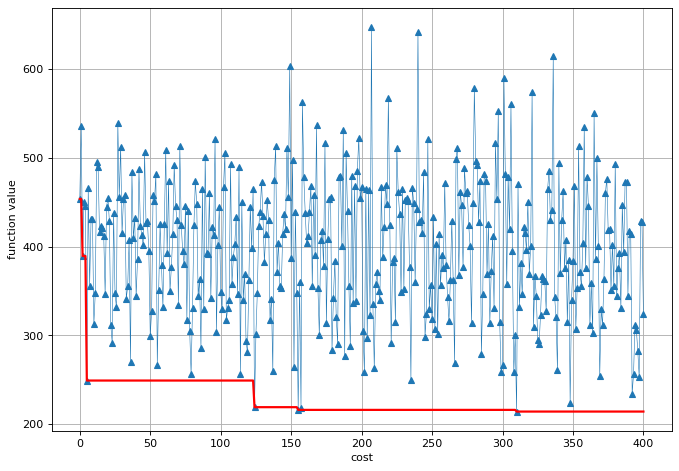

In [18]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot([t[1] for t in history], "-^", lw=0.5)
pl.xlabel("cost")
pl.plot(np.minimum.accumulate([t[1] for t in history]), 'r', lw=2)
pl.ylabel("function value")
pl.grid(True)
# pl.ylim([0, 20]) 

## Minima of GD

In [19]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y), y_best

(array([7.6191, 7.5838, 7.8202, 7.33  , 7.6084, 7.2716, 7.1965, 7.7112,
        9.5198, 8.14  , 9.1107, 7.314 , 8.5631, 7.2789, 8.7475, 8.472 ,
        7.1138, 7.9899, 8.444 , 8.9118]),
 214.38847576741492,
 310,
 214.38847576741492)

In [20]:
gp.get_normal()

(402.6928082499606, 78.48229783160755)

In [21]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [22]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []
for a in X_fix:
    history_ucb.append( (a, f(a)) )

In [23]:
cost = setup + warmup
while cost < MAX:
    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=2000)
    # 2. GP_UCB
#     b = np.log(cost**gp.dim)
#     arg_min = np.argmin(mu.reshape(-1,1) - np.sqrt(b)*s.reshape(-1, 1)) # discrete version
#     w = Grid[arg_min]
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    

#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print('  y_best: ', np.min(f(gp.X)))
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

16. w:  [9.0942 8.7477 9.4963 8.1578 9.5061 7.6485 7.6356 7.3502 9.5765 8.0731
 8.7657 9.2347 9.1603 9.0401 9.7421 7.0537 7.2031 9.1653 7.9193 7.4642]
  f(w):  440.9815515849656
  y_best:  249.29612432257773

17. w:  [8.2485 8.4454 7.4023 7.6566 8.3946 8.7911 7.765  8.3489 8.334  7.5222
 9.8922 9.7566 7.001  9.7224 9.2749 9.7263 7.8999 9.4315 9.8078 9.6561]
  f(w):  457.7867368554637
  y_best:  249.29612432257773

18. w:  [9.5787 8.2322 7.7257 8.2295 7.5967 9.6336 9.1814 8.7045 9.5953 8.0646
 9.3842 9.8567 7.8503 9.4933 8.1295 9.5216 8.7902 9.8068 9.4164 9.9258]
  f(w):  527.991647208333
  y_best:  249.29612432257773

  # Optimal (ls, var) =  (0.5455471317824623, 1.0375027547614175)
19. w:  [9.8649 9.0527 9.7756 8.4619 8.9517 8.8579 9.5349 9.8229 7.3189 7.7327
 8.8527 8.0547 7.7548 8.6732 8.3572 9.338  8.1689 8.9699 7.705  8.9927]
  f(w):  424.3992487176507
  y_best:  249.29612432257773

20. w:  [9.0692 9.5201 7.7577 8.9299 9.2964 7.5113 8.2446 9.7648 8.9409 9.745
 9.9107 8.0713 7.0291

52. w:  [8.1514 8.7121 9.3189 7.2945 8.196  9.7304 8.4401 8.4946 8.277  8.9938
 8.0273 9.6059 8.3904 9.6145 9.1179 9.3715 7.2038 7.5117 7.6177 9.4235]
  f(w):  417.8111287204226
  y_best:  186.74260009007793

53. w:  [9.0756 8.1031 7.9511 7.2422 7.9383 7.8131 8.8411 8.9069 8.1856 8.9664
 7.8171 9.5518 9.5133 7.9423 9.8455 8.1446 8.2634 9.4733 8.4505 7.0302]
  f(w):  353.1571133561022
  y_best:  186.74260009007793

54. w:  [7.8107 8.0049 9.4719 7.7302 8.2626 9.4478 8.5782 8.6602 9.2959 8.8213
 9.1709 9.0767 7.7094 9.0255 8.6216 8.5522 8.3826 8.3678 8.6283 9.3002]
  f(w):  409.2929104048108
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (0.44163763291178054, 1.0328935273823168)
55. w:  [8.7622 8.5623 8.2684 8.1885 7.8891 9.9753 9.5125 8.8203 8.2469 8.1495
 8.2015 8.9746 8.7961 7.9201 8.7464 8.0297 7.5786 7.6812 9.8589 9.6767]
  f(w):  342.38015347736757
  y_best:  186.74260009007793

56. w:  [9.5783 8.4747 8.3548 8.4371 7.2059 8.7626 9.0239 9.6186 8.984  8.2094
 8.5676 7.312  9.

88. w:  [9.4826 7.8834 8.4133 9.1881 9.5257 8.9859 8.332  9.853  9.8171 9.1011
 9.2763 9.9389 8.1839 7.3234 8.802  9.4292 7.9488 8.2533 8.9367 8.1756]
  f(w):  516.6158695539071
  y_best:  186.74260009007793

89. w:  [7.2277 8.5769 7.8801 8.5864 8.4039 8.6635 8.2598 9.5416 8.6407 9.7365
 9.7538 8.3608 9.8449 8.7639 8.3722 9.8847 7.6633 7.6273 7.5475 7.5935]
  f(w):  420.82549002400617
  y_best:  186.74260009007793

90. w:  [7.5195 9.3415 9.3893 8.6544 9.1837 9.8074 7.7749 8.5013 9.5246 7.4434
 8.3017 9.2271 8.1556 8.5703 8.7096 8.926  8.319  7.3684 8.2515 9.1327]
  f(w):  425.3774980619305
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (0.41345995282781944, 1.0366561499705522)
91. w:  [9.9882 9.539  9.5176 7.8092 8.7107 8.5836 8.9619 7.131  8.6136 9.1788
 7.4877 8.7712 9.603  8.9136 8.4089 9.2124 8.2057 9.4351 7.9063 8.343 ]
  f(w):  458.9979115861608
  y_best:  186.74260009007793

92. w:  [9.0182 7.9292 9.5718 8.3085 8.5402 9.4429 8.1225 8.3439 7.0386 7.5726
 7.6138 7.763  7.

125. w:  [8.1241 8.9594 8.962  7.396  9.7805 8.5961 9.3893 8.5352 9.4669 9.624
 9.0716 8.4105 7.8772 8.2754 8.3588 9.2905 9.4245 7.1308 9.1035 8.4124]
  f(w):  505.3830136284292
  y_best:  186.74260009007793

126. w:  [9.2918 9.5161 9.104  9.1642 8.8283 9.8706 8.2035 9.3823 7.4768 8.7622
 8.2017 8.1778 8.7854 8.078  8.9992 8.5456 8.8646 7.8572 8.6991 7.1478]
  f(w):  430.20513262181134
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (0.29601367512684934, 1.0419110459468106)
127. w:  [7.6428 8.7928 7.7613 8.8566 8.9856 8.3686 8.5837 7.8353 8.2353 9.9562
 9.5678 8.9539 7.4795 8.2112 8.6326 7.0903 9.4906 9.0819 7.979  7.2045]
  f(w):  389.715016476367
  y_best:  186.74260009007793

128. w:  [9.3066 7.884  9.5141 9.1625 9.4216 8.5756 7.9551 8.2249 8.7223 9.1578
 7.0742 8.3696 9.2099 8.031  7.5405 7.8899 8.3653 9.8711 9.5507 7.3291]
  f(w):  413.6610463054662
  y_best:  186.74260009007793

129. w:  [9.8854 8.0805 8.0812 7.2871 8.3292 7.3008 7.2788 9.7154 9.881  9.4096
 8.2861 9.4646

161. w:  [8.4875 8.8072 9.1262 7.999  7.706  7.34   7.5829 9.2946 9.3809 7.3356
 9.7787 7.3571 8.4871 7.0078 8.7863 8.7968 8.3755 9.9828 8.9459 7.0473]
  f(w):  397.58889588396187
  y_best:  186.74260009007793

162. w:  [7.0952 7.1011 9.5869 9.0038 7.3366 9.9936 8.7403 7.3515 8.8414 9.946
 8.1578 8.5267 7.1059 7.1727 8.2056 9.9228 7.4632 7.4033 9.6543 8.5406]
  f(w):  418.9713787990509
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (0.6098444365857589, 1.026686040555597)
163. w:  [7.2813 8.6471 8.5689 7.1446 7.1128 7.0965 8.0217 7.2737 8.8929 9.523
 9.7062 8.1702 8.9171 9.979  9.1323 7.6449 9.6963 8.7395 9.858  8.8478]
  f(w):  460.95907820733504
  y_best:  186.74260009007793

164. w:  [8.8343 8.0169 8.6585 7.5237 8.6326 8.342  9.8148 8.0668 7.62   7.7296
 9.1118 7.4346 7.8992 7.1366 9.094  8.4765 9.5898 8.3847 7.8851 7.2868]
  f(w):  291.22895712745515
  y_best:  186.74260009007793

165. w:  [7.9232 7.0858 7.4328 9.5889 7.1017 7.7513 9.4318 7.4807 8.5891 8.7876
 7.4382 9.7155

197. w:  [7.576  8.3992 8.4238 9.0214 8.7626 7.8052 7.5212 9.0705 7.2881 7.3679
 8.0257 7.1313 9.7445 8.4221 8.9936 8.7413 7.5532 8.3249 9.8061 7.224 ]
  f(w):  334.8814702428831
  y_best:  186.74260009007793

198. w:  [8.4254 7.469  7.2507 7.562  7.791  8.1249 9.9358 9.1677 9.8687 8.4543
 7.9355 8.7439 7.3338 7.1494 9.5915 9.8958 9.1344 9.3483 7.7766 8.1276]
  f(w):  413.5923160157981
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (1.0, 1.017588378062158)
199. w:  [7.1579 7.2844 9.8451 9.4109 7.6728 9.0431 8.5548 7.1766 8.3199 7.4766
 7.6841 7.2606 7.9556 7.479  9.9023 7.9147 7.0097 7.2219 7.2996 7.3893]
  f(w):  275.78881584284164
  y_best:  186.74260009007793

200. w:  [8.0556 8.6957 8.8213 8.1823 9.6124 7.3989 8.2847 8.9922 9.3931 7.5954
 9.9272 8.4138 8.2254 7.5842 7.4333 7.8816 9.8149 8.8538 7.9737 8.7559]
  f(w):  372.41576638853275
  y_best:  186.74260009007793

201. w:  [7.6747 7.6332 9.6203 9.7727 9.6457 8.4669 8.8289 9.2917 8.7228 9.7695
 8.8753 9.8231 7.0077 7.1284

233. w:  [8.2442 8.6869 7.9559 8.9726 7.6431 9.1237 9.0434 7.8283 8.9045 9.0278
 9.322  9.7955 9.1625 7.7968 8.2354 7.4432 7.8222 8.9893 8.2877 9.7119]
  f(w):  398.02031776538223
  y_best:  186.74260009007793

234. w:  [8.5143 8.8289 8.5634 7.2829 8.9034 9.038  8.85   7.8232 8.3182 7.9205
 9.5563 7.463  8.93   9.3002 7.4755 8.6371 9.8752 9.6056 7.726  9.5559]
  f(w):  417.2637451575188
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (1.0, 1.0074824836615075)
235. w:  [7.472  9.6521 7.2319 8.3526 8.4624 8.4    8.5886 8.2205 9.953  9.0697
 8.149  9.0446 8.515  8.5942 7.8663 8.7139 9.4468 7.2449 9.1854 9.6596]
  f(w):  407.9004033590875
  y_best:  186.74260009007793

236. w:  [9.1555 8.7795 9.4484 9.4424 9.5822 8.9541 7.2903 9.0483 9.1906 7.1129
 9.4975 7.9819 7.8057 9.4564 7.8478 7.642  7.316  9.2324 8.4674 7.4144]
  f(w):  456.3238670874706
  y_best:  186.74260009007793

237. w:  [9.295  9.0481 7.6729 8.0346 7.732  9.1984 7.0708 7.9387 9.349  8.4326
 7.3353 9.3939 8.5984 7.2639

269. w:  [9.8947 8.1647 8.226  9.2979 8.4657 7.0647 9.7801 7.9379 8.6038 9.535
 8.5874 7.5236 9.119  7.6633 7.9194 7.2254 8.036  8.6936 8.342  7.1048]
  f(w):  313.1717277303161
  y_best:  186.74260009007793

270. w:  [9.877  9.5945 7.3423 9.8675 7.4294 7.5513 8.5108 9.6288 8.8002 9.9132
 8.2397 7.7617 8.0133 8.962  7.8248 9.6571 8.5186 9.8123 9.0602 7.6201]
  f(w):  469.8292168171915
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (0.57845594425365, 1.0067662951840317)
271. w:  [7.768  7.4446 8.1704 7.2339 9.116  9.1312 9.7274 8.7647 7.1865 7.5936
 9.54   8.7157 9.9157 9.2345 7.0366 8.9214 7.8925 9.4988 7.4054 8.153 ]
  f(w):  441.67407396951785
  y_best:  186.74260009007793

272. w:  [9.7028 8.122  7.5585 7.3988 7.0007 8.1315 9.9333 9.4335 9.8105 8.0077
 7.4946 8.0839 8.0933 7.0193 8.1741 9.8442 7.6672 9.7913 7.0935 9.5399]
  f(w):  340.966855345704
  y_best:  186.74260009007793

273. w:  [7.5893 8.71   8.8261 9.3638 8.5176 9.3069 7.4374 8.7587 8.773  8.899
 7.3596 8.9117 7.9

305. w:  [9.5695 8.1931 8.8719 8.2204 8.8081 9.4924 7.4578 7.8948 8.9381 8.3594
 8.8032 8.8573 8.4475 7.1866 7.5692 9.7121 8.8228 9.0567 9.7052 9.806 ]
  f(w):  413.7325381665215
  y_best:  186.74260009007793

306. w:  [7.0901 8.5096 8.6518 7.7964 7.4688 7.4394 8.2301 8.9284 8.9556 8.003
 8.711  7.7479 8.8932 9.4984 9.4025 8.0603 9.7904 7.9601 8.5043 8.4129]
  f(w):  349.5629893501724
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (1.0, 1.0000608083609215)
307. w:  [9.349  8.7676 9.1134 9.6555 8.9798 7.0102 8.3722 8.3746 9.6159 8.1503
 8.0775 7.3598 8.1856 7.5977 9.169  9.5358 9.8368 9.2648 8.6082 8.8207]
  f(w):  457.2016550582754
  y_best:  186.74260009007793

308. w:  [7.7588 7.0229 8.4183 7.8036 7.048  9.5934 9.1687 8.1969 7.2423 8.6135
 9.7765 7.3932 8.5407 7.8485 8.771  8.2232 7.8782 9.1282 8.4245 8.3533]
  f(w):  320.84751356441245
  y_best:  186.74260009007793

309. w:  [9.4407 9.1271 8.8069 9.7369 9.2044 7.6665 9.8761 7.3143 9.6191 8.9662
 7.1636 9.4718 8.3322 9.9944 

341. w:  [7.8965 7.0521 8.6927 9.4362 7.5255 7.2206 8.3642 9.6523 9.9007 8.8148
 7.323  8.9325 9.4765 9.8166 8.9596 8.311  9.0261 9.9237 7.6656 7.8698]
  f(w):  499.3728004330288
  y_best:  186.74260009007793

342. w:  [8.4021 9.3852 8.8688 7.5969 7.4569 8.7604 7.35   7.6752 7.1331 9.6292
 8.0001 8.119  9.2598 7.4394 9.504  8.6623 8.4674 7.6486 9.7785 8.7648]
  f(w):  367.19989982567125
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (0.5175871881743918, 1.005360445069761)
343. w:  [8.2847 8.764  7.7604 7.2798 8.7678 9.8211 7.1954 9.2273 9.615  7.7482
 9.461  8.6948 7.0075 9.3485 9.7086 9.8902 7.3735 9.9857 7.0707 8.9101]
  f(w):  506.4489589967582
  y_best:  186.74260009007793

344. w:  [7.9632 8.1383 7.2625 7.2479 7.3754 7.696  8.645  8.4399 9.6298 7.053
 8.8424 8.0835 9.6425 8.0385 9.4093 9.6609 9.3542 9.8636 9.8252 7.7992]
  f(w):  459.3931260150287
  y_best:  186.74260009007793

345. w:  [7.4914 9.0856 7.229  7.1798 8.6406 7.382  7.669  9.6885 8.2724 8.901
 9.2041 9.7762 9

377. w:  [9.8923 7.1334 7.8541 7.0588 7.3528 9.1709 9.0327 9.5137 7.9196 9.0909
 9.3407 9.05   9.713  7.4759 7.9574 7.5441 9.355  9.4555 7.3092 9.3566]
  f(w):  426.5946844745042
  y_best:  186.74260009007793

378. w:  [7.0334 7.9482 8.1057 9.3667 7.3559 7.9794 7.2893 9.7063 7.6269 8.3869
 7.0068 9.4067 7.9585 7.9568 7.4331 9.5651 7.6395 8.5732 8.0198 8.7809]
  f(w):  281.6720395405901
  y_best:  186.74260009007793

  # Optimal (ls, var) =  (1.0, 0.993329925040499)
379. w:  [8.3662 8.0239 7.3207 9.7509 7.2058 7.3903 8.7712 8.891  7.7922 8.4439
 7.5997 8.5117 9.6033 7.5386 7.8474 9.2291 8.429  9.1436 7.549  7.9685]
  f(w):  316.91370333823613
  y_best:  186.74260009007793

380. w:  [7.8971 8.0345 8.9576 8.4583 9.9408 7.8245 9.5823 7.4476 9.3125 9.4041
 9.88   7.89   9.8435 9.4432 7.2114 7.1044 7.6801 8.4366 7.6033 9.0964]
  f(w):  443.24145085984327
  y_best:  186.74260009007793

381. w:  [8.2585 7.1445 9.1535 7.6734 8.6039 9.949  9.126  7.12   9.3886 9.6205
 7.2847 9.938  9.6449 7.4722

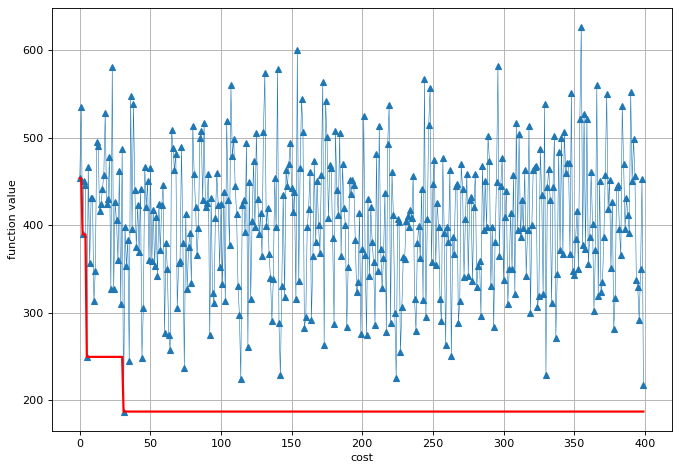

In [24]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot([t[1] for t in history_ucb], "-^", lw=0.5)
pl.xlabel("cost")
pl.plot(np.minimum.accumulate([t[1] for t in history_ucb]), 'r', lw=2)
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [25]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([7.3232, 7.8371, 7.7651, 7.8441, 7.5293, 7.2597, 7.5626, 7.5663,
        7.0509, 8.9488, 7.1343, 7.6733, 7.0857, 7.4306, 8.9052, 8.5548,
        9.238 , 7.5629, 7.2471, 8.1656]),
 186.74260009007793,
 31)

In [26]:
gp.get_hyper()

{'var': 1.0024415510744944, 'lengthscale': 0.49340807236293915}

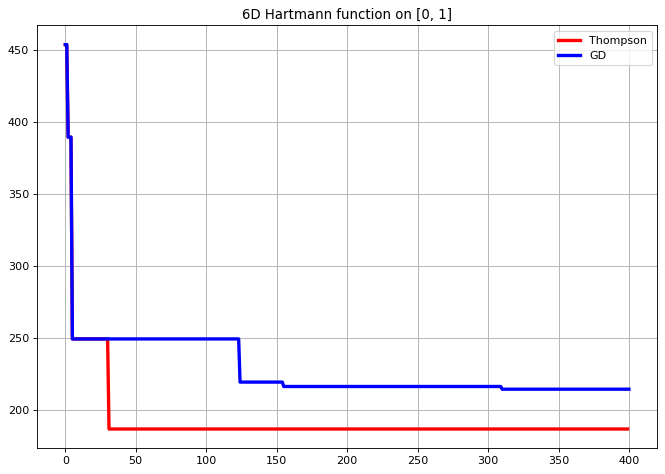

In [27]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate([t[1] for t in history_ucb]), 'r', lw=3, label='Thompson')
# pl.plot(np.minimum.accumulate(np.array(history_EI)[:, 1]), 'b', lw=2, label='EI')
pl.plot(np.minimum.accumulate([t[1] for t in history]), 'b', lw=3, label='GD')
pl.title("6D Hartmann function on [0, 1]")
pl.legend()
pl.grid(True)
# pl.ylim([0, 20])

In [28]:
# import pickle
# file_name = "./pkl/compress_running_min_momentum6.pkl" 

# open_file = open(file_name, "wb")
# pickle.dump(np.minimum.accumulate([t[1] for t in history]), open_file)
# open_file.close()

# open_file = open(file_name, "rb")
# loaded_list = pickle.load(open_file)
# open_file.close()

In [29]:
# file_name = "./pkl/compress_running_min_thompson6.pkl" 

# open_file = open(file_name, "wb")
# pickle.dump(np.minimum.accumulate([t[1] for t in history_ucb]), open_file)
# open_file.close()

# open_file = open(file_name, "rb")
# loaded_list = pickle.load(open_file)
# open_file.close()